# Predicting the NBA Finals Champion: What Makes a Championship Team?

Naa'Oli Mamie

##Introduction

An NBA season is roughly divided into two parts. First is the regular season, where each NBA team plays a total of 82 games fighting for a chance to qualify for the second part of the season, the NBA Playoffs (plus Play-In Tournament). The NBA Playoffs is a 16 team, best-of-seven elimination tournament that crowns the Champion of the season. For an NBA fan, it is the most exciting and fun time of the year. The basketball community discusses who the tournament favorite is, which players will perform especially well, and what surprises there might be. Besides countless fan bets made on the favorite team, many basketball experts try their hand at predicting the NBA champion every year. History shows that predicting the champion before the start of the NBA Playoffs is almost impossible. Looking back at the start of the 2022 NBA Playoffs, only two out of 50 basketball experts correctly chose the Golden State Warriors to win it all.

So, is winning an NBA championship really as random as praying that luck looks your way? In this project, we will dive deep in the statistics of basketball and look into what truly makes an NBA champion. By the end, hopefully we will be able to accurately pick this year's champion as well.

**Facts to Consider**

*   Over the past 25 championship seasons, 24 championship teams have ranked within the top 6 in the league in terms of margin of victory. This finding underscores the importance of team dominance and outperforming opponents.

*   An overwhelming majority of 23 out of the last 25 championship teams boasted a top 5 regular season record in the league. This observation highlights the significance of sustained success throughout the duration of the season.
*   Additionally, 24 out of the last 25 championship teams held an SRS (simple rating system) score that ranked within the league's top 6. This statistic underscores the overall strength and quality of these teams.

In [37]:
# imports
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

url_start = "https://www.basketball-reference.com/leagues/NBA_{}.html"
years = range(1998,2024)

## Data Collection and Cleaning

We will be obtaining the majority of our data from [Basketball Reference](https://www.basketball-reference.com/), a website often use by basketball and data science enthusiasts to look into how their favorite player or team is perfoming. We will scrape data from the past 25 seasons as well as this recent regular season, using the past 25 championship teams as a reference to find trends throughout history in order to predict this year's champion. We will locally save the files to minimize the amount of HTTP requests we are calling as Basketball Reference has a limit to the number of HTTP requests we can make.

In [3]:
for year in years:
  url = url_start.format(year)
  data = requests.get(url)
  with open("season/{}.html".format(year), "w+") as f:
    f.write(data.text)

Now, with the .html files for each season saved in the season folder, we can now go through each season and extract what we need. The information we will be using is the per game statistics for each team and the opponents of each team as well.

## Data Processing

Since Basketball Reference has the team stats and the opponent stats split into two tables, we will need to save each table as a Pandas Dataframe, then merge the two dataframes. We will also be removing the rank columns from both tables as it is simply an index, and removing the games player and minutes played from the opponent stats table as it is the same statistic shown in the team stats table. Basketball Reference also has an asterik at the end of each playoff team's name, but we will be creating a column that represents whether a team made the playoffs.

We will also create a column that represents whether a team won the championship by pulling the championship team name from the top of the webpage.

In [11]:
dfs = []

for year in years:
  # Pulling both Team Stats and Opponent Stats from the HTML and storing in a DF
  with open("season/{}.html".format(year)) as f:
    page = f.read()
  soup = bs(page, "html.parser")

  # Removes League Average Footer
  soup.find('tfoot').decompose()

  # Championship Team
  data = '' 
  champion_name = "";
  for data in soup.find('div', {'id': 'info'}).find_all("p"): 
    if "League Champion" in data.get_text():
      champion_name = data.get_text()[17:]
      break;


  # All Team Stats
  team_stats_table = soup.find(id="per_game-team")
  opp_stats_table = soup.find(id="per_game-opponent")
  team_stats = pd.read_html(str(team_stats_table))[0].sort_values("Team")
  opp_stats = pd.read_html(str(opp_stats_table))[0].sort_values("Team")

  # Merging the Team Stats and the Opponent Stats in the same DF
  opp_stats = opp_stats.drop(columns=['Rk', 'G', 'MP'])
  team_stats = team_stats.drop(columns=['Rk'])
  opp_stats.columns = ['Team'] + ['OPP_' + column if column != 'Team' else column for column in opp_stats.columns[1:]]
  merged_df = team_stats.merge(opp_stats, on='Team')

  # Playoff and Champion Columns
  merged_df['Playoff'] = False
  merged_df['Champion'] = False
  for index, row in merged_df.iterrows():
    team_name = row['Team']
    if team_name.endswith('*'):
      merged_df.at[index, 'Playoff'] = True
      merged_df.at[index, 'Team'] = team_name.rstrip('*')
    if merged_df.at[index, 'Team'] == champion_name:
      merged_df.at[index, 'Champion'] = True

  merged_df['Year'] = year
  dfs.append(merged_df)

stats = pd.concat(dfs)
stats

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,OPP_TRB,OPP_AST,OPP_STL,OPP_BLK,OPP_TOV,OPP_PF,OPP_PTS,Playoff,Champion,Year
0,Atlanta Hawks,82,242.4,35.2,77.5,0.455,4.1,12.4,0.332,31.1,...,39.4,21.4,7.5,4.5,13.6,23.1,92.3,True,False,1998
1,Boston Celtics,82,240.6,36.7,84.6,0.434,5.1,15.2,0.332,31.7,...,42.2,22.3,8.5,5.0,20.6,21.0,98.5,False,False,1998
2,Charlotte Hornets,82,241.2,36.2,77.4,0.468,4.2,11.0,0.383,32.0,...,39.3,22.0,7.1,4.5,15.1,23.2,94.6,True,False,1998
3,Chicago Bulls,82,242.1,37.4,82.9,0.451,3.8,11.7,0.323,33.6,...,39.7,19.5,8.0,4.3,15.5,21.6,89.6,True,True,1998
4,Cleveland Cavaliers,82,241.8,34.4,75.7,0.454,3.6,9.8,0.372,30.7,...,38.7,21.8,8.6,5.5,17.6,23.2,89.8,True,False,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Sacramento Kings,82,241.8,43.6,88.2,0.494,13.8,37.3,0.369,29.8,...,42.2,26.7,7.3,4.2,14.2,20.9,118.1,True,False,2023
26,San Antonio Spurs,82,242.1,43.1,92.6,0.465,11.1,32.2,0.345,32.0,...,45.0,26.8,8.1,5.3,13.8,18.5,123.1,False,False,2023
27,Toronto Raptors,82,241.5,41.9,91.3,0.459,10.7,32.0,0.335,31.1,...,42.3,26.2,6.0,4.6,16.7,19.6,111.4,True,False,2023
28,Utah Jazz,82,241.5,42.5,89.8,0.473,13.3,37.8,0.353,29.2,...,43.5,25.0,7.8,4.9,12.6,20.5,118.0,False,False,2023


### Margin of Victory


We now have one dataframe that we can access simple statistics. Let's add some more advanced statistics commonly used in the basketball realm through calculations.

Margin of Victory is how much a team wins/loses a game by. We can find the average margin of victory by subtracting the opponent's points per game by the team's points per game.

In [12]:
stats['MOV'] = stats['PTS'] - stats['OPP_PTS']
stats.head()

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,OPP_AST,OPP_STL,OPP_BLK,OPP_TOV,OPP_PF,OPP_PTS,Playoff,Champion,Year,MOV
0,Atlanta Hawks,82,242.4,35.2,77.5,0.455,4.1,12.4,0.332,31.1,...,21.4,7.5,4.5,13.6,23.1,92.3,True,False,1998,3.6
1,Boston Celtics,82,240.6,36.7,84.6,0.434,5.1,15.2,0.332,31.7,...,22.3,8.5,5.0,20.6,21.0,98.5,False,False,1998,-2.6
2,Charlotte Hornets,82,241.2,36.2,77.4,0.468,4.2,11.0,0.383,32.0,...,22.0,7.1,4.5,15.1,23.2,94.6,True,False,1998,2.0
3,Chicago Bulls,82,242.1,37.4,82.9,0.451,3.8,11.7,0.323,33.6,...,19.5,8.0,4.3,15.5,21.6,89.6,True,True,1998,7.1
4,Cleveland Cavaliers,82,241.8,34.4,75.7,0.454,3.6,9.8,0.372,30.7,...,21.8,8.6,5.5,17.6,23.2,89.8,True,False,1998,2.7


### Team Seeding and SRS

The two next useful statistics are the seed of the team and the SRS score of the team. The seed of the team is how well an NBA team perfomed in the regular season compared to others. Usually, seeding is split between conferences (East and West), but we will also need to know the seeding compared to all teams in the league. In order for us to get these stats, we need to pull the wins, losses, and conference seeding from the webpage. We will pull from the division standing as we will not need to use a browser to load in the division standings.

The division standings tables have some cleaning up to do, such as changing the header from Eastern Conference / Western Conference to Team and remove the asterik at the end of playoff teams. We also want to store the Year and Conference of each team. 

After we clean up these tables, we will add a column for conference seeding, then merge the two dataframes together and add a column for league seeding.

The SRS score (Simple Rating System) is a rating that takes into account average point differential and strength of schedule. [You can learn more about what an SRS score means and how it is calculated here.](https://www.basketball-reference.com/blog/indexba52.html?p=39) Instead of calculating the SRS score for each team ourselves, we can pull that from the webpage as well.

In [13]:
seedings = []
for year in years:
  with open("season/{}.html".format(year)) as f:
    page = f.read()

  soup = bs(page, "html.parser")
  east_table = soup.find(id="divs_standings_E")
  east = pd.read_html(str(east_table))[0]
  east['Year'] = year
  east['Team'] = east['Eastern Conference'].str.replace("*", "", regex=False)
  del east['Eastern Conference']
  east['Conference'] = "East"
  east = east[~east['W'].str.contains("Division")]


  east = east.sort_values(by="W", ascending=False)

  west_table = soup.find(id="divs_standings_W")
  west = pd.read_html(str(west_table))[0]
  west['Year'] = year
  west['Team'] = west['Western Conference'].str.replace("*", "", regex=False)
  del west['Western Conference']
  west['Conference'] = "West"
  west = west.sort_values(by="W", ascending=False)
  west = west[~west['W'].str.contains("Division")]

  # Seeds by conference
  east['Conf Seed'] = list(range(1,east.shape[0] + 1))
  west['Conf Seed'] = list(range(1,west.shape[0] + 1))

  combined = pd.concat([east, west])
  combined = combined[['Team', 'Year', 'W', 'L', 'W/L%', 'SRS', 'Conf Seed']]

  combined = combined.reset_index(drop=True)

  # Seeds relative to the entire league
  combined = combined.sort_values(by="W", ascending=False)
  combined['Seed'] = list(range(1,combined.shape[0] + 1))

  combined['Team'] = combined['Team'].str.replace(r'\xa0\(\d+\)', '', regex=True)

  seedings.append(combined)

seedings = pd.concat(seedings)

# Merging the win/loss dataframe to the main one
stats = stats.merge(seedings, how="outer", on=['Team', 'Year'])
stats

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,Playoff,Champion,Year,MOV,W,L,W/L%,SRS,Conf Seed,Seed
0,Atlanta Hawks,82,242.4,35.2,77.5,0.455,4.1,12.4,0.332,31.1,...,True,False,1998,3.6,50,32,.610,3.85,5,10
1,Boston Celtics,82,240.6,36.7,84.6,0.434,5.1,15.2,0.332,31.7,...,False,False,1998,-2.6,36,46,.439,-1.96,12,21
2,Charlotte Hornets,82,241.2,36.2,77.4,0.468,4.2,11.0,0.383,32.0,...,True,False,1998,2.0,51,31,.622,2.45,4,9
3,Chicago Bulls,82,242.1,37.4,82.9,0.451,3.8,11.7,0.323,33.6,...,True,True,1998,7.1,62,20,.756,7.24,1,1
4,Cleveland Cavaliers,82,241.8,34.4,75.7,0.454,3.6,9.8,0.372,30.7,...,True,False,1998,2.7,47,35,.573,3.06,6,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,Sacramento Kings,82,241.8,43.6,88.2,0.494,13.8,37.3,0.369,29.8,...,True,False,2023,2.6,48,34,.585,2.30,3,7
769,San Antonio Spurs,82,242.1,43.1,92.6,0.465,11.1,32.2,0.345,32.0,...,False,False,2023,-10.1,22,60,.268,-9.82,15,29
770,Toronto Raptors,82,241.5,41.9,91.3,0.459,10.7,32.0,0.335,31.1,...,True,False,2023,1.5,41,41,.500,1.59,8,18
771,Utah Jazz,82,241.5,42.5,89.8,0.473,13.3,37.8,0.353,29.2,...,False,False,2023,-0.9,37,45,.451,-1.03,12,22


Let us make sure all of the variable types are correct.

In [14]:
stats.dtypes

Team          object
G              int64
MP           float64
FG           float64
FGA          float64
FG%          float64
3P           float64
3PA          float64
3P%          float64
2P           float64
2PA          float64
2P%          float64
FT           float64
FTA          float64
FT%          float64
ORB          float64
DRB          float64
TRB          float64
AST          float64
STL          float64
BLK          float64
TOV          float64
PF           float64
PTS          float64
OPP_FG       float64
OPP_FGA      float64
OPP_FG%      float64
OPP_3P       float64
OPP_3PA      float64
OPP_3P%      float64
OPP_2P       float64
OPP_2PA      float64
OPP_2P%      float64
OPP_FT       float64
OPP_FTA      float64
OPP_FT%      float64
OPP_ORB      float64
OPP_DRB      float64
OPP_TRB      float64
OPP_AST      float64
OPP_STL      float64
OPP_BLK      float64
OPP_TOV      float64
OPP_PF       float64
OPP_PTS      float64
Playoff         bool
Champion        bool
Year         

Looks like the data we just inputted is stored as an object, let's change those to numeric values.

In [15]:
stats = stats.apply(pd.to_numeric, errors="ignore")

stats.dtypes


### Ranked Stats

Let's create a dataframe of each champion and where they rank amongst the league in each statistical category we are tracking. This way, we can see trends amongst championship teams and use it to predict the next NBA champion.

We will go through year by year and find the ranked stats of each champion. Note: the higher the better for team stats, but the lower the better for opponent stats. A team with the highest points will rank first in points, but a team with the highest opponent points will rank last. We will not be ranking seeds as seeding is already a rank dependent on wins.

In [25]:
ranked = []

for year in years:
  rk_stats = pd.DataFrame()
  year_data = stats[stats['Year'] == year]
  for column_name, column_data in year_data.items():
    # Not ranking non numerical statistics, ranked statistics, and wins/losses
    if column_name not in ["Team","Champion","Playoff","Year", "Conf Seed", "Seed", "W", "L"]:
      if "OPP" in column_name:
        rk_stats[column_name + "_RK"] = column_data.rank(ascending=True)
      else:
        rk_stats[column_name + "_RK"] = column_data.rank(ascending=False)
    elif column_name in ['Team', 'Year']:
      rk_stats[column_name] = column_data
  ranked.append(rk_stats)

ranked = pd.concat(ranked)
stats = stats.merge(ranked, how="outer",on=['Team','Year'])

stats

##Exploratory analysis & Data viz

Now that we have our data cleaned and in one place, let's plot some of the statistics amongst champions and find general trends. We will be using MatPlotLib to generate plots. [The general documentation can be explored here](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.plot.html)

To analyze the distribution of each statistic, we can create histograms using matplotlib. Let's consider the "SRS_RK" statistic as an example. We can plot separate histograms for championship and non-championship teams to visualize their respective distributions and identify any differences. 

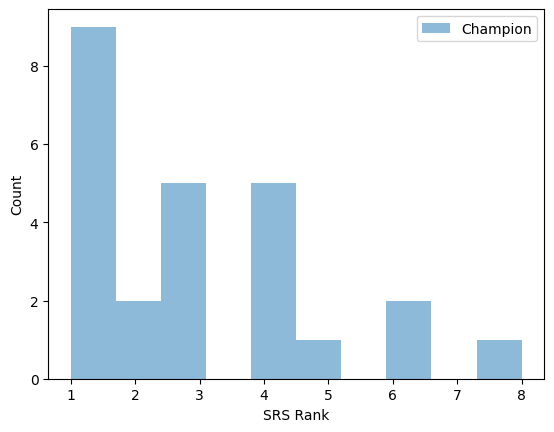

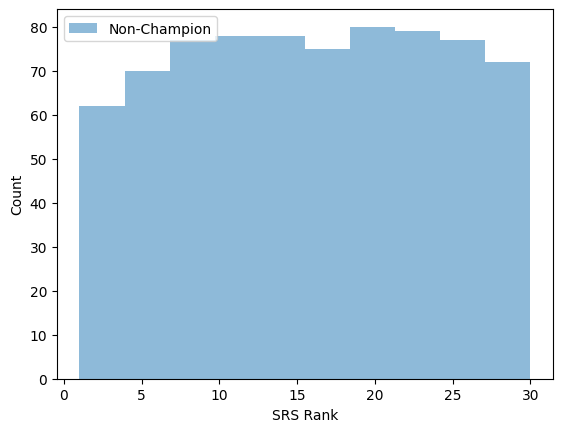

In [28]:
# Histogram for championship teams
plt.hist(stats[stats["Champion"]]["SRS_RK"], alpha=0.5, label="Champion")
plt.xlabel("SRS Rank")
plt.ylabel("Count")
plt.legend()
plt.show()

# Histogram for non-championship teams
plt.hist(stats[~stats["Champion"]]["SRS_RK"], alpha=0.5, label="Non-Champion")
plt.xlabel("SRS Rank")
plt.ylabel("Count")
plt.legend()
plt.show()

In addition to analyzing the distribution of each statistic, we can also explore the relationships between the statistics and the champion status using scatter plots. For instance, let's examine the relationship between "MOV_RK" (Margin of Victory Rank) and a team's seed relative to the rest of the league. We can plot a scatter plot where the points are colored based on the champion status. 


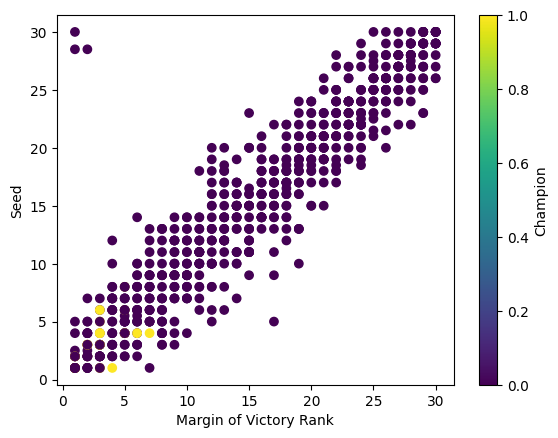

In [31]:
plt.scatter(stats["Seed"], stats["SRS_RK"], c=stats["Champion"])
plt.xlabel("Margin of Victory Rank")
plt.ylabel("Seed")
plt.colorbar(label="Champion")
plt.show()


We can see that not only that SRS and a team's seed are highly correlated, which makes sense as a team with a higher margin of victory tends to do well in getting wins, but also that championship teams tend to rank at the top of the league in SRS score, Margin of Victory, and seeding.

## Hypothesis Testing

Hypothesis testing is a crucial component of our analysis, as it allows us to statistically evaluate the significance of relationships and differences between the provided statistics (Seed, MOV_RK, and SRS_RK) and the champion status of NBA teams. By formulating appropriate hypotheses and selecting suitable statistical tests, we can determine the strength of these relationships and draw meaningful conclusions.

To demonstrate the process of hypothesis testing, let's consider two examples: testing the mean difference in "Seed," "MOV_RK," and "SRS_RK" between champion and non-champion teams and examining the independence between "Conf Seed" (Conference Seed) and the champion status.

Hypothesis test for mean difference in "Seed," "MOV_RK," and "SRS_RK" between champion and non-champion teams:
* Null Hypothesis: There is no significant difference in the mean "Seed," "MOV_RK," and "SRS_RK" between champion and non-champion teams.
*  Alternative Hypothesis: There is a significant difference in the mean "Seed," "MOV_RK," and "SRS_RK" between champion and non-champion teams.

We can use a t-test to assess whether the mean "Seed," "MOV_RK," and "SRS_RK" differ significantly between the two groups.


In [33]:
champion_stats = stats[stats["Champion"]]
non_champion_stats = stats[~stats["Champion"]]

# Perform the t-test for Seed
t_stat_seed, p_value_seed = ttest_ind(champion_stats["Seed"], non_champion_stats["Seed"])

# Perform the t-test for MOV_RK
t_stat_mov, p_value_mov = ttest_ind(champion_stats["MOV_RK"], non_champion_stats["MOV_RK"])

# Perform the t-test for SRS_RK
t_stat_srs, p_value_srs = ttest_ind(champion_stats["SRS_RK"], non_champion_stats["SRS_RK"])

# Interpret the results for Seed
if p_value_seed < 0.05:
    print("Reject the null hypothesis for Seed. There is a significant difference in the mean Seed between champion and non-champion teams.")
else:
    print("Fail to reject the null hypothesis for Seed. There is no significant difference in the mean Seed between champion and non-champion teams.")

# Interpret the results for MOV_RK
if p_value_mov < 0.05:
    print("Reject the null hypothesis for MOV_RK. There is a significant difference in the mean MOV_RK between champion and non-champion teams.")
else:
    print("Fail to reject the null hypothesis for MOV_RK. There is no significant difference in the mean MOV_RK between champion and non-champion teams.")

# Interpret the results for SRS_RK
if p_value_srs < 0.05:
    print("Reject the null hypothesis for SRS_RK. There is a significant difference in the mean SRS_RK between champion and non-champion teams.")
else:
    print("Fail to reject the null hypothesis for SRS_RK. There is no significant difference in the mean SRS_RK between champion and non-champion teams.")

Reject the null hypothesis for Seed. There is a significant difference in the mean Seed between champion and non-champion teams.
Reject the null hypothesis for MOV_RK. There is a significant difference in the mean MOV_RK between champion and non-champion teams.
Reject the null hypothesis for SRS_RK. There is a significant difference in the mean SRS_RK between champion and non-champion teams.


After these hypothesis tests, we can conclude that there is a significant relationship between being a champion and a team's Seed, Margin of Victory, and SRS score rankings.

## Machine Learning

Machine learning allows us to develop predictive models that can accurately forecast the likelihood of a team becoming an NBA champion based on the provided statistics (Seed, MOV_RK, and SRS_RK). By training and evaluating machine learning algorithms on historical data, we can leverage the patterns and relationships discovered to make predictions for future championship outcomes.


Before proceeding with machine learning modeling, it is important to preprocess and prepare the data. This involves splitting the dataset into training and testing sets, handling missing values, encoding categorical variables if necessary, and scaling the numerical features. 

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select relevant features and target variable
features = stats[["Seed", "MOV_RK", "SRS_RK"]]
target = stats["Champion"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Perform feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Next, we need to choose suitable machine learning models for our classification task. In this project, we have chosen to use Logistic Regression and Random Forest models. Here's the reasoning behind selecting these models:

* Logistic Regression: Logistic Regression is a widely used and interpretable algorithm for binary classification tasks. It works well when there is a linear relationship between the features and the log-odds of the target variable. Given that we have numerical features like Seed, MOV_RK, and SRS_RK, Logistic Regression can capture the relationships between these variables and the champion status effectively.

* Random Forest: Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. It is a versatile algorithm that can handle both numerical and categorical features, and it has the ability to capture non-linear relationships between the input variables and the target variable. Random Forest can provide robust predictions by reducing overfitting and incorporating feature importance analysis.

In [36]:
# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train_scaled, y_train)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

# Predict the champion status for the test set using Logistic Regression
y_pred_logreg = logreg_model.predict(X_test_scaled)

# Predict the champion status for the test set using Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the models
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_logreg = classification_report(y_test, y_pred_logreg)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Print the evaluation metrics for Logistic Regression
print("Logistic Regression Model:")
print("Accuracy:", accuracy_logreg)
print("Classification Report:\n", classification_report_logreg)
print()

# Print the evaluation metrics for Random Forest
print("Random Forest Model:")
print("Accuracy:", accuracy_rf)
print("Classification Report:\n", classification_report_rf)


Logistic Regression Model:
Accuracy: 0.967741935483871
Classification Report:
               precision    recall  f1-score   support

       False       0.97      1.00      0.98       150
        True       0.00      0.00      0.00         5

    accuracy                           0.97       155
   macro avg       0.48      0.50      0.49       155
weighted avg       0.94      0.97      0.95       155


Random Forest Model:
Accuracy: 0.9548387096774194
Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.99      0.98       150
        True       0.00      0.00      0.00         5

    accuracy                           0.95       155
   macro avg       0.48      0.49      0.49       155
weighted avg       0.94      0.95      0.95       155



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Once the models are trained and evaluated, we can assess their performance using various metrics such as accuracy, precision, recall, and F1-score. These metrics provide insights into the models' predictive capabilities and their ability to correctly classify championship outcomes. Additionally, feature importance analysis can be conducted to determine the significance of each input variable in predicting the champion status. This analysis helps us understand the key factors contributing to a team's championship success.

In [38]:

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_score_logreg = f1_score(y_test, y_pred_logreg)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_score_rf = f1_score(y_test, y_pred_rf)

# Print the evaluation metrics for Logistic Regression
print("Logistic Regression Model:")
print("Accuracy:", accuracy_logreg)
print("Precision:", precision_logreg)
print("Recall:", recall_logreg)
print("F1-Score:", f1_score_logreg)
print()

# Print the evaluation metrics for Random Forest
print("Random Forest Model:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-Score:", f1_score_rf)
print()

# Calculate and print feature importances for Random Forest
feature_importances = rf_model.feature_importances_
for feature, importance in zip(features.columns, feature_importances):
    print(f"{feature}: {importance}")


Logistic Regression Model:
Accuracy: 0.967741935483871
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Random Forest Model:
Accuracy: 0.9548387096774194
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Seed: 0.3877575213561986
MOV_RK: 0.30215177662962645
SRS_RK: 0.3100907020141751


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Prediction!

To predict the top 6 most likely teams to win the 2023 NBA championship, we will utilize the trained Logistic Regression and Random Forest models. We will input the statistics of the teams competing in the playoffs, including their seeding position, margin of victory ranking, and simple rating system ranking. The predictions will provide insights into which teams are considered the strongest contenders for the championship. Finally, we will plot the results on a pie graph to visualize the probabilities of the top 6 teams winning the championship.

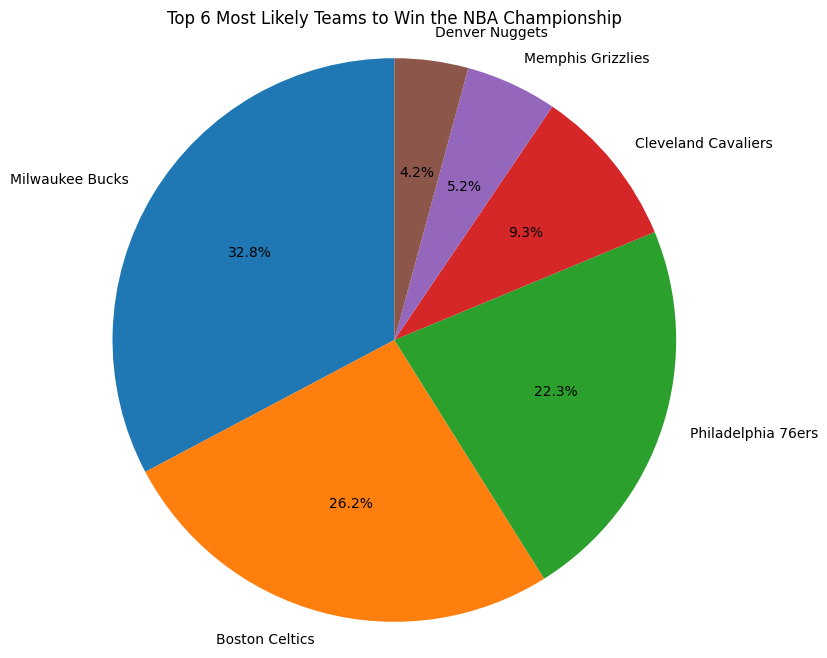

In [43]:
new_data = stats[stats['Year'] == 2023]

new_data_scaled = scaler.transform(new_data[['Seed', 'MOV_RK', 'SRS_RK']])

# Predict the champion probabilities using Logistic Regression
champion_probabilities_logreg = logreg_model.predict_proba(new_data_scaled)[:, 1]

# Predict the champion probabilities using Random Forest
champion_probabilities_rf = rf_model.predict_proba(new_data_scaled)[:, 1]

# Combine the probabilities from both models
combined_probabilities = (champion_probabilities_logreg + champion_probabilities_rf) / 2

# Create a dictionary to store team probabilities
team_probabilities = dict(zip(new_data['Team'], combined_probabilities))

# Sort the teams based on their probabilities in descending order
sorted_teams = sorted(team_probabilities.items(), key=lambda x: x[1], reverse=True)

# Select the top 6 teams and their probabilities
top_6_teams = sorted_teams[:6]
top_6_team_names = [team[0] for team in top_6_teams]
top_6_probabilities = [team[1] for team in top_6_teams]

# Plotting the results on a pie graph
plt.figure(figsize=(8, 8))
plt.pie(top_6_probabilities, labels=top_6_team_names, autopct='%1.1f%%', startangle=90)
plt.title("Top 6 Most Likely Teams to Win the NBA Championship")
plt.axis('equal')
plt.show()

And there you have it, the top six teams that are most likely to win the NBA championship in 2023. When dealing with sports predictions, it's always key to make sure that there goes more into predicting sports, such as unfortunate injuries, that make sports predictions all the more challenging. But if history tells us anything, one of these six teams will most likely win the NBA championship, with the Milwaukee Bucks having the highest probability.